# Notebook to show results

Import libraries needed

In [99]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.patches as mpatches

In [100]:
from modules.config import (RESULTS_DIR,
                            RESULTS_FILE, 
                            GRAPH_DIR,
                            )

SPACE = ' '
SHOW_COUNTS = True # Show how much many relevant datapoints have been read?

## Define standard function modules

In [101]:
def read_data():
    """read data from csv file into pandas dataframe"""
    results_path = Path(RESULTS_DIR).joinpath(RESULTS_FILE)
    df = pd.read_csv(results_path)
    return df

In [102]:
def filter_results_general(df):
    """based on standard parameters"""    
    df = df[(df['formulation'] == 'original')]
    df = df[(df['hot_start'] == False)]
    df = df[(df['gray'] == False)]
    df = df[(df['iterations'] == 250)]
    return df

Filter out records for analysis

In [103]:
def filter_results_qml(df):
    """based on standard parameters"""    
    df = df[(df['quantum'] == True)]
    df = filter_results_general(df)
    df = df[(df['gradient_type'] == 'SPSA')]
    df = df[(df['alpha'] == 0.602)]
    df = df[(df['big_a'] == 25)]
    df = df[(df['c'] == 0.314)]
    df = df[(df['gamma'] == 0.101)]
    df = df[(df['eta'] == 0.1)]
    df = df[(df['s'] == 0.5)]
    df = df[(df['shots'] == 1024)]
    return df

In [104]:
def filter_results_ml(df):
    """based on standard parameters"""    
    df = df[(df['quantum'] == False)]
    df = filter_results_general(df)
    df = df[(df['shots'] == 64)]
    df = df[(df['std_dev'] == 0.05)]
    df = df[(df['lr'] == 2e-5)]
    df = df[(df['weight_decay'] == 0.0006)]
    df = df[(df['momentum'] == 0.8)]
    return df

In [105]:
def find_quality(df, factor=1):
    df['quality'] =  factor* df['best_dist'] / df['best_dist_found'] 
    df['error'] = 1 * factor - df['quality']
    return df

In [106]:
def select_key_fields_qml(df):
    df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode',]]
    return df

In [107]:
def select_key_fields_ml(df):
    df = df[['locations', 'iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'layers', 'elapsed']]
    return df

## Analysis of slicing

In [108]:
df = read_data()
df = filter_results_qml(df)
df = find_quality(df)
df = select_key_fields_qml(df)
df = df[(df['mode'] == 2)]
df = df[(df['locations'] > 8)]
df.head()

,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
169,10,1.0,2,290.2,290.2,1.000000,0.000000,2
179,10,1.0,73,290.2,290.2,1.000000,0.000000,2
192,10,1.0,116,290.2,290.2,1.000000,0.000000,2
204,10,1.0,12,290.3,290.2,0.999656,0.000344,2
671,9,1.0,181,286.7,286.7,1.000000,0.000000,2


In [109]:
grouped = df.groupby(['locations', 'slice'])
sliced_summary = grouped['error'].agg(
    mean='mean',
    sem='sem'
).reset_index()
sliced_summary = sliced_summary.rename(columns={'mean': 'error'})
sliced_summary.head()

,locations,slice,error,sem
0,9,0.1,0.000000,0.000000
1,9,0.2,0.000000,0.000000
2,9,0.3,0.000418,0.000418
3,9,0.4,0.000418,0.000418
4,9,0.5,0.000000,0.000000


In [110]:
def plot_3d_graph_models(grouped_means, input, input2 = 'layers'):
    """plot a 3D bar graph of the given input data grouped by layers and locations"""   
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    input2_vals = sorted(grouped_means[input2].unique())
    locations = sorted(grouped_means['locations'].unique(), reverse=True)

    input2_map = {sli: i for i, sli in enumerate(input2_vals)}
    loc_map = {loc: i for i, loc in enumerate(locations)}
    
    # Assign colors for each location
    colors = plt.get_cmap('Set3', len(input2_vals))  # or 'Set3', 'Paired', etc.
    input2_colors = {item: colors(i) for i, item in enumerate(input2_vals)}

    # Bar sizes
    dx = 0.5
    dy = 0.15

    # Plot bars with different colors
    for i, row in grouped_means.iterrows():
        x = loc_map[row['locations']] - dx/2    # Center the bar on the x-axis
        y = input2_map[row[input2]] - dy/2  # Center the bar on the y-axis
        z = 0
        dz = row[input]

        color = input2_colors[row[input2]]
        ax.bar3d(x, y, z, dx, dy, dz, color=color, shade=True)

    # Label axes
    ax.set_xlabel('Locations')
    ax.set_ylabel(input2)
    ax.set_zlabel(input)

    # Set tick labels
    ax.set_xticks(list(loc_map.values()))
    ax.set_xticklabels(list(loc_map.keys()))
    ax.set_yticks(list(input2_map.values()))
    ax.set_yticklabels(list(input2_map.keys()))

    legend_handles = [mpatches.Patch(color=input2_colors[layer], label=layer) for layer in input2_vals]

    plt.legend(handles=legend_handles, title=input2, loc='upper left', bbox_to_anchor=(1, 1))

    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

    formatted_input = input.replace('_', SPACE).lower()
    title = f'3D bar graph of {formatted_input} by {input2} and locations'
    plt.title(title)
    filepath = Path(GRAPH_DIR).joinpath(title)
    plt.savefig(filepath)
    plt.show()

In [111]:
def plot_3d_graph_slice(grouped_means, input, show_sem=False):
    """plot a 3D bar graph of the given input data grouped by locations and slice."""   
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Map categorical data to numeric positions
    locations = grouped_means['locations'].unique()
    slices = sorted(grouped_means['slice'].unique())

    loc_map = {loc: i for i, loc in enumerate(locations)}
    slice_map = {sli: i for i, sli in enumerate(slices)}

    # Assign colors for each location
    colors = plt.get_cmap('Set3', len(locations))  # or 'Set3', 'Paired', etc.
    location_colors = {loc: colors(i) for i, loc in enumerate(locations)}

    # Bar and cap width sizes
    dx = 0.5
    dy = 0.25
    cap_width = 0.1

    # Plot bars with different colors
    for i, row in grouped_means.iterrows():
        x = slice_map[row['slice']]   
        y = loc_map[row['locations']]
        x_bar = slice_map[row['slice']] - dx/2    # Center the bar on the x-axis
        y_bar = loc_map[row['locations']] - dy/2  # Center the bar on the y-axis
        z_bar = 0
        dz = row[input]
        if show_sem:
            error = row['sem']

        color = location_colors[row['locations']]
        ax.bar3d(x_bar , y_bar, z_bar, dx, dy, dz, color=color, shade=True)
        
        x_center = x + dx / 4
        y_center = y + dy / 4
        y_center = y

        if show_sem:
            if error > 0:
                #error bars
                ax.plot(
                    [x_center , x_center],
                    [y_center, y_center],
                    [0, dz + error],
                    color='black',
                    linewidth=2
                    )     
                # Horizontal cap at the top
                ax.plot(
                    [x_center - cap_width, x_center + cap_width],
                    [y_center, y_center],
                    [dz + error, dz + error],
                    color='black',
                    linewidth=2
                    )
    # Label axes
    ax.set_xlabel('Slice')
    ax.set_ylabel('Locations')
    ax.set_zlabel(input)

    # Set tick labels
    ax.set_xticks(list(slice_map.values()))
    ax.set_xticklabels(list(slice_map.keys()))
    ax.set_yticks(list(loc_map.values()))
    ax.set_yticklabels(list(loc_map.keys()))

    legend_handles = [mpatches.Patch(color=location_colors[loc], label=loc) for loc in locations]
    plt.legend(handles=legend_handles, title='Locations', loc='upper left', bbox_to_anchor=(1, 1))

    formatted_input = input.replace('_', SPACE).lower()
    title = f'3D bar graph of {formatted_input} by location and slice'
    plt.title(title)
    filepath = Path(GRAPH_DIR).joinpath(title)
    plt.savefig(filepath)
    plt.show()

In [112]:
sliced_summary.head()

,locations,slice,error,sem
0,9,0.1,0.000000,0.000000
1,9,0.2,0.000000,0.000000
2,9,0.3,0.000418,0.000418
3,9,0.4,0.000418,0.000418
4,9,0.5,0.000000,0.000000


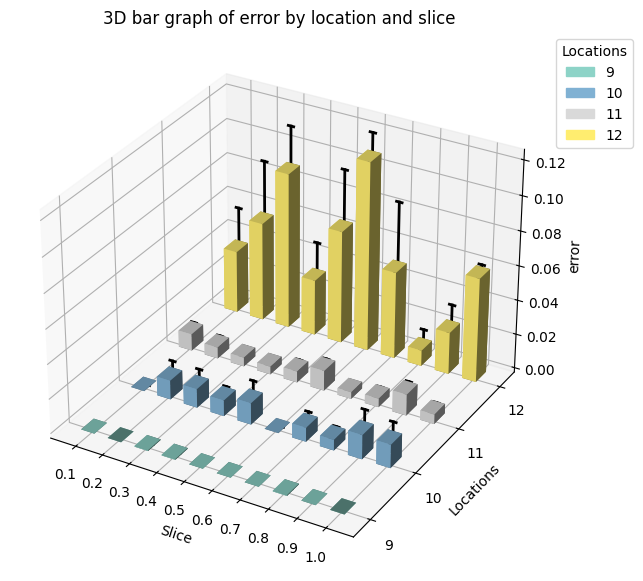

In [113]:
input = 'error'
plot_3d_graph_slice(sliced_summary, input, show_sem=True)

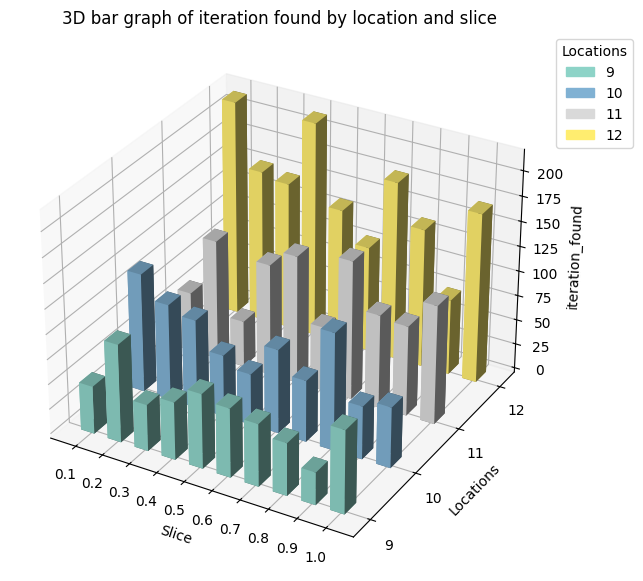

In [114]:
sliced_summary = grouped['iteration_found'].agg(
    mean='mean',
    sem='sem'
).reset_index()

sliced_summary = sliced_summary.rename(columns={'mean': 'iteration_found'})
sliced_summary.head()

input = 'iteration_found'
plot_3d_graph_slice(sliced_summary, input, show_sem=False)

## Analysis of qml models

In [115]:
df = read_data()
df = filter_results_qml(df)
df = find_quality(df)
df = select_key_fields_qml(df)
df = df[(df['slice'] == 1.0)]

In [116]:
mode_summary = df.groupby(['mode', 'locations']).mean().reset_index()
mode_summary.head()

,mode,locations,slice,iteration_found,best_dist_found,best_dist,quality,error
0,1,4,1.0,0.0,21.0,21.0,1.0,0.0
1,1,5,1.0,0.0,19.0,19.0,1.0,0.0
2,1,6,1.0,5.0,241.0,241.0,1.0,0.0
3,1,7,1.0,0.0,276.2,276.2,1.0,0.0
4,1,8,1.0,2.5,277.2,277.2,1.0,0.0


## Analysis of ml models with different numbers of layers

In [117]:
df = read_data()
df = filter_results_ml(df)
df = find_quality(df)
df = select_key_fields_ml(df)
df = df[(df['mode'] == 8)]
df['layers'] = df['layers'].astype(int)

In [118]:
df.head()

,locations,iteration_found,best_dist_found,best_dist,quality,error,mode,layers,elapsed
573,10,6,447.100006,290.2,0.649072,0.350928,8,2,202.633927
591,10,9,328.700012,290.2,0.882872,0.117128,8,2,208.004263
610,10,26,356.700012,290.2,0.813569,0.186431,8,1,215.333851
611,10,4,424.500000,290.2,0.683628,0.316372,8,2,222.882087
612,10,5,422.700012,290.2,0.686539,0.313461,8,2,200.864060


In [119]:
layers_summary = df.groupby(['layers','locations', ]).mean().reset_index()
layers_summary.head()

,layers,locations,iteration_found,best_dist_found,best_dist,quality,error,mode,elapsed
0,1,4,0.0,21.000000,21.0,1.000000,0.000000,8.0,36.065529
1,1,5,0.0,19.000000,19.0,1.000000,0.000000,8.0,51.213325
2,1,6,0.0,256.299988,241.0,0.940304,0.059696,8.0,77.375575
3,1,7,2.0,308.000000,276.2,0.896753,0.103247,8.0,118.169566
4,1,8,51.0,277.700012,277.2,0.998199,0.001801,8.0,146.837071


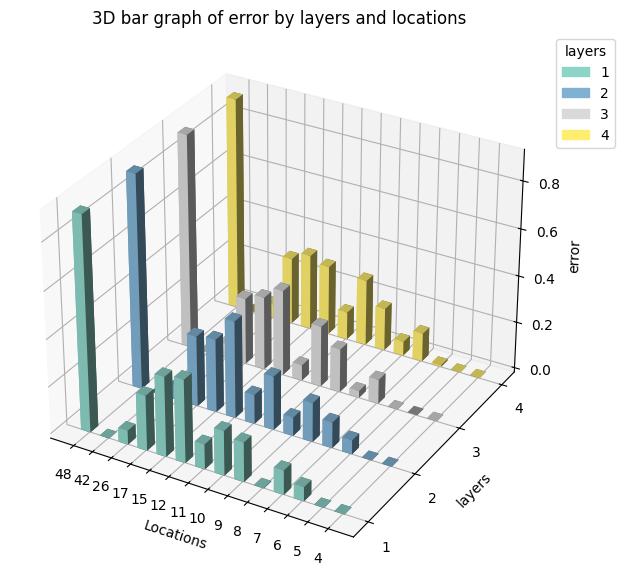

In [120]:
input = 'error'
plot_3d_graph_models(layers_summary, input)

In [121]:
layers_means = df.groupby(['locations', 'layers',]).mean().reset_index()

In [122]:
ml_means = layers_means.groupby(['layers',]).mean().reset_index()
ml_means.head()

,layers,locations,iteration_found,best_dist_found,best_dist,quality,error,mode,elapsed
0,1,15.714286,28.202381,8708.421429,1185.821429,0.820098,0.179902,8.0,609.542481
1,2,15.714286,39.928571,8823.215476,1185.821429,0.802947,0.197053,8.0,589.913110
2,3,15.714286,30.000000,9039.450001,1185.821429,0.816347,0.183653,8.0,637.501351
3,4,15.714286,37.114286,8585.378572,1185.821429,0.811653,0.188347,8.0,621.925547


# Impact of hot start

### QML - hot start

In [123]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]


df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'hot_start']]


In [124]:
hot_qml_mean = df.groupby(['locations', 'hot_start',]).mean().reset_index()

In [125]:
pivot = hot_qml_mean.pivot_table(index='locations', columns='hot_start', values='quality')
pivot = pivot.round(1)
print(pivot)

hot_start  False  True 
locations              
4          100.0  100.0
5          100.0  100.0
6          100.0  100.0
7          100.0  100.0
8          100.0  100.0
9          100.0  100.0
10          99.4   98.9
11          99.5  100.0
12          99.1   93.3


In [126]:
hot_summary = hot_qml_mean.groupby(['hot_start',]).mean().reset_index()
hot_summary.head()

,hot_start,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,False,8.0,0.8,45.679718,218.611746,217.944444,99.770988,0.229012,2.0
1,True,8.0,0.8,75.488889,220.664444,217.944444,99.137975,0.862025,2.0


### Classical ML - hot start

In [127]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'hot_start']]


In [128]:
hot_ml_mean = df.groupby(['locations', 'hot_start',]).mean().reset_index()

In [129]:
pivot = hot_ml_mean.pivot_table(index='locations', columns='hot_start', values='quality')
pivot = pivot.round(1)
print(pivot)

hot_start  False  True 
locations              
4          100.0  100.0
5          100.0  100.0
6           98.1   88.7
7           88.5  100.0
8           93.7   94.6
9           83.2  100.0
10          78.1   91.7
11          88.9   93.0
12          67.4   78.8
15          67.9   70.4
17          72.0   70.7
26          94.1   78.0
42         100.0   77.7
48           9.3    9.4


In [130]:
hot_ml_summary = hot_ml_mean.groupby(['hot_start',]).mean().reset_index()
hot_ml_summary.head()

,hot_start,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,False,15.714286,1.0,35.788690,8685.901092,1185.821429,81.514809,18.485191,8.011905
1,True,15.714286,1.0,44.311224,8664.162758,1185.821429,82.342026,17.657974,8.020408


## Impact of Gray encoding

### QML - Gray

In [131]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'gray']]

gray_mean_qml = df.groupby(['locations', 'gray',]).mean().reset_index()
if SHOW_COUNTS:
    gray_mean_qml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    gray_mean_qml = df.groupby(['locations', 'gray',]).mean().reset_index()
gray_qml_pivot = gray_mean_qml.pivot_table(index='locations', columns='gray', values='quality')
gray_qml_pivot = gray_qml_pivot.round(1)
print(gray_qml_pivot)


gray       False  True 
locations              
4            5.0    5.0
5            5.0    5.0
6            5.0    5.0
7            5.0    5.0
8            5.0    5.0
9            5.0    5.0
10           9.0    9.0
11           7.0    7.0
12           3.0    3.0


In [132]:

gray_summary_qml = gray_mean_qml.groupby(['gray',]).mean().reset_index()
gray_summary_qml.head(20)

,gray,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,False,8.0,5.444444,5.444444,5.444444,5.444444,5.444444,5.444444,5.444444
1,True,8.0,5.444444,5.444444,5.444444,5.444444,5.444444,5.444444,5.444444


### Classical ML - Gray

In [133]:

df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]
df = df[(df['mode'] == 8)]
df = df[(df['layers'] == 4)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'gray', ]]

if SHOW_COUNTS:
    gray_mean_ml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    gray_mean_ml = df.groupby(['locations', 'gray',]).mean().reset_index()

In [134]:
gray_ml_pivot = gray_mean_ml.pivot_table(index='locations', columns='gray', values='quality')
gray_ml_pivot = gray_ml_pivot.round(2)
print(gray_ml_pivot)

gray       False  True 
locations              
4            5.0   10.0
5            5.0   10.0
6            5.0    9.0
7            5.0    9.0
8            5.0    9.0
9            5.0    9.0
10           5.0    9.0
11           5.0    9.0
12           5.0    9.0
15           5.0    9.0
17           5.0    9.0
26           5.0    9.0
42           5.0    9.0
48           5.0    9.0


In [135]:
gray_summary_ml = gray_mean_ml.groupby(['gray',]).mean().reset_index()
gray_summary_ml.head(20)

,gray,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,False,15.714286,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
1,True,15.714286,9.142857,9.142857,9.142857,9.142857,9.142857,9.142857,9.142857


## Impact of formalation

### QML - formulation

In [149]:
df = read_data()
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'formulation',]]

form_mean_qml = df.groupby(['locations', 'formulation',]).mean().reset_index()
if SHOW_COUNTS:
    form_mean_qml = df.groupby(['locations', 'formulation',]).count().reset_index()
else:
    form_mean_qml = df.groupby(['locations', 'formulation',]).mean().reset_index()
form_qml_pivot = form_mean_qml.pivot_table(index='locations', columns='formulation', values='quality')
form_qml_pivot = form_qml_pivot.round(1)
print(form_qml_pivot)


formulation  new  original
locations                 
4            5.0       5.0
5            5.0       5.0
6            5.0       5.0
7            5.0       5.0
8            5.0       5.0
9            5.0       5.0
10           5.0       9.0
11           3.0       7.0
12           3.0       3.0


In [137]:
form_summary_qml = form_mean_qml.groupby(['formulation',]).mean().reset_index()
form_summary_qml.head()

,formulation,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,new,8.0,4.555556,4.555556,4.555556,4.555556,4.555556,4.555556,4.555556
1,original,8.0,5.444444,5.444444,5.444444,5.444444,5.444444,5.444444,5.444444


## Classical ML formulation

In [151]:
df = read_data()
df = df[(df['gray'] == False)]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]
df = df[(df['mode'] == 8)]
df = df[(df['layers'] == 4)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'formulation', ]]

if SHOW_COUNTS:
    form_mean_ml = df.groupby(['locations', 'formulation',]).count().reset_index()
else:
    form_mean_ml = df.groupby(['locations', 'formulation',]).mean().reset_index()

form_ml_pivot = form_mean_ml.pivot_table(index='locations', columns='formulation', values='quality')
form_ml_pivot = form_ml_pivot.round(1)
print(form_ml_pivot)

formulation  new  original
locations                 
4            2.0       5.0
5            2.0       5.0
6            2.0       5.0
7            2.0       5.0
8            2.0       5.0
9            2.0       5.0
10           2.0       5.0
11           1.0       5.0
12           1.0       5.0
15           1.0       5.0
17           1.0       5.0
26           NaN       5.0
42           NaN       5.0
48           NaN       5.0


## Impact of changing minibatch size for ML

In [139]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['mode'] == 8)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['runid'] == '20250427-22-43-45')]

df = find_quality(df, factor=100)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed']]

if SHOW_COUNTS:
    shots_mean_ml = df.groupby(['locations', 'shots',]).count().reset_index()
else:
    shots_mean_ml = df.groupby(['locations', 'shots',]).mean().reset_index()

shots_ml_pivot = shots_mean_ml.pivot_table(index='locations', columns='shots', values='quality')
shots_ml_pivot = shots_ml_pivot.round(1)
print(shots_ml_pivot)

shots      2    4    8    16   32   64   128  256
locations                                        
4          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
5          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
6          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
7          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
8          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
9          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
10         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
11         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
12         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
15         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
17         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
26         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
42         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
48         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0


In [140]:
df.head()

,locations,iteration_found,quality,error,shots,elapsed
1380,4,0,100.000000,0.000000,2,7.906193
1381,5,45,100.000000,0.000000,2,2.292913
1382,6,2,94.030438,5.969562,2,3.179127
1383,7,96,99.999996,0.000004,2,4.051808
1384,8,84,82.377415,17.622585,2,5.390921


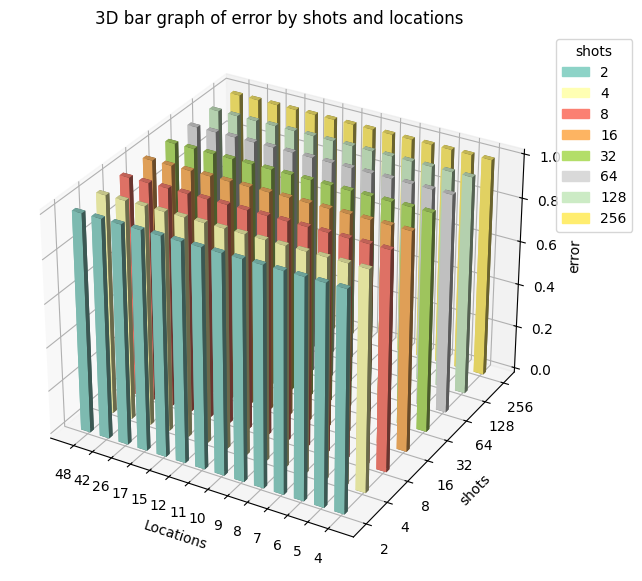

(None,)

In [141]:
input = 'error'
plot_3d_graph_models(shots_mean_ml, input, input2='shots'), 

In [142]:
shots_summary_ml = df.groupby(['shots',]).mean().reset_index()
shots_summary_ml.drop(columns=['locations'], inplace=True)
shots_summary_ml.drop(columns=['error'], inplace=True)
shots_summary_ml['elapsed'] = shots_summary_ml['elapsed'].astype(int)
shots_summary_ml['iteration_found'] = shots_summary_ml['iteration_found'].round(1)
shots_summary_ml['quality'] = shots_summary_ml['quality'].round(1)
print(shots_summary_ml.to_string(index=False))

 shots  iteration_found  quality  elapsed
     2             71.0     78.8       20
     4             79.3     80.1       42
     8             49.1     78.0       84
    16             41.2     78.6      166
    32             32.2     82.3      331
    64             35.4     80.9      658
   128             41.2     85.0     1346
   256             35.6     87.4     2891


## Impact of models on QML

In [143]:
df = read_data()
df = filter_results_qml(df)
df = find_quality(df)
df = select_key_fields_qml(df)
df = df[(df['slice'] == 0.8)]
df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 
         'quality', 'error','mode', ]]

In [144]:
df.head()

,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
680,4,0.8,0,21.0,21.0,1.0,0.0,2
681,5,0.8,0,19.0,19.0,1.0,0.0,2
682,6,0.8,0,241.0,241.0,1.0,0.0,2
683,7,0.8,0,276.2,276.2,1.0,0.0,2
684,8,0.8,1,277.2,277.2,1.0,0.0,2


In [145]:
mode_mean_qml = df.groupby(['locations', 'mode',]).mean().reset_index()
mode_mean_qml.head()


,locations,mode,slice,iteration_found,best_dist_found,best_dist,quality,error
0,4,1,0.8,0.0,21.0,21.0,1.0,0.0
1,4,2,0.8,0.0,21.0,21.0,1.0,0.0
2,5,1,0.8,0.0,19.0,19.0,1.0,0.0
3,5,2,0.8,0.0,19.0,19.0,1.0,0.0
4,6,1,0.8,0.6,241.0,241.0,1.0,0.0


In [146]:
summary_mean_qml = df.groupby([ 'mode',]).mean().reset_index()
summary_mean_qml.head()


,mode,locations,slice,iteration_found,best_dist_found,best_dist,quality,error
0,1,7.243243,0.8,24.378378,207.429730,205.586486,0.993982,0.006018
1,2,8.122449,0.8,49.673469,222.740816,222.038776,0.997561,0.002439
